# 1. Setup & Dependencies

In [ ]:
# Install requirements.tx

!pip install -r requirements.txt

In [ ]:
!pip install --upgrade torch torchvision

In [ ]:
!python --version

In [ ]:
# Check cuda version

!nvcc --version

## 1.1. Import statements

In [1]:
%matplotlib inline

In [2]:
import os

# Configure Pytorch to use 'cudaMallocAsync' as the allocator
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'backend:cudaMallocAsync'

In [3]:
import torch
import torch.nn as nn
import time
import gc
import matplotlib.pyplot as plt
from torchinfo import summary
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

## 1.2. Device configuration

In [4]:
def get_device() -> torch.device:
    """Get the best available device for PyTorch."""
    if torch.cuda.is_available():
        device = "cuda"

        # The flag below controls whether to allow TF32 on matmul.
        torch.backends.cuda.matmul.allow_tf32 = True
        # The flag below controls whether to allow TF32 on cuDNN.
        torch.backends.cudnn.allow_tf32 = True

        # Print GPU info
        print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")

        # Set up GPU memory management
        memory_limit_mb = 4095.5  # Adjust as needed

        # Fetching total memory of GPU
        total_memory = torch.cuda.get_device_properties(0).total_memory
        print(f"Total GPU memory: {total_memory / 1024**2:.2f} MB")

        # Setting memory limit
        memory_limit = memory_limit_mb * 1024 ** 2
        memory_fraction = memory_limit / total_memory
        torch.cuda.set_per_process_memory_fraction(memory_fraction, device=0)

        print(f"Set GPU memory fraction to {memory_fraction:.2%}")

        # Empty cache to measure memory usage
        torch.cuda.empty_cache()
    elif torch.backends.mps.is_available():
        device = "mps"
        print("Using Apple Silicon MPS device")
    else:
        device = "cpu"
        print("Using CPU device")

    return torch.device(device)

In [5]:
# GPU optimization
torch.set_float32_matmul_precision('high')

# Set device
device = get_device()

Using CUDA device: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Total GPU memory: 4095.50 MB
Set GPU memory fraction to 100.00%


In [6]:
pin_memory = True if device.type == 'cuda' else False
pin_memory_device = 'cuda' if device.type == 'cuda' else ''

# 2. Load & transform data

In [7]:
# Input shape constants, width, height, and number of channels
IMG_WIDTH = 384
IMG_HEIGHT = 216
IMG_CHANNELS = 3

## 2.1. Normalize the dataset

In [8]:
# Transform without normalization
initial_transforms = v2.Compose([
    v2.Resize((IMG_WIDTH, IMG_HEIGHT)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

In [9]:
# Create temporary dataset to calculate mean and std
temp_dataset = ImageFolder(root='../data/merged_pool', transform=initial_transforms)

temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False, num_workers=6, pin_memory=pin_memory, pin_memory_device=pin_memory_device)

In [10]:
calc_stats = True

if calc_stats:
    print(f"Computing dataset statistics using device: {device}")
    print(f"Number of images to process: {len(temp_dataset)}")

    # Initialize tensors to accumulate the sum and squared sum of channels
    channels_sum = torch.zeros(3, device=device)
    channels_sqrd_sum = torch.zeros(3, device=device)
    num_batches = 0
    start_time = time.time()

    # Iterating over the data loader with a progress bar
    for batch_idx, (data, _) in enumerate(tqdm(temp_loader, desc="Computing mean/std")):
        # Move data to the specified device
        data = data.to(device, non_blocking=True)

        # Used mixed precision for faster computation
        with autocast(device.type):
            # Calculating and adding the mean and squared mean of each channel
            channels_sum += torch.mean(data, dim=[0, 2, 3])
            channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

        if batch_idx % 10 == 0:
            batch_time = time.time() - start_time
            print(f"\nProcessed {batch_idx * temp_loader.batch_size} images in {batch_time:.2f}s")

    # Calculate overall mean and standard deviation
    mean = channels_sum / num_batches
    std = torch.sqrt((channels_sqrd_sum / num_batches) - (mean ** 2))

    mean = mean.cpu().tolist()
    std = std.cpu().tolist()

    total_time = time.time() - start_time
    print(f"\nTotal processing time: {total_time:.2f} seconds")
    print(f"Dataset mean: {mean}")
    print(f"Dataset std: {std}")

    # Release memory
    del temp_dataset, temp_loader, channels_sum, channels_sqrd_sum, data
    gc.collect()

    torch.cuda.empty_cache()
else:
    mean=[0.5479778051376343, 0.526210367679596, 0.4944702088832855]
    std=[0.2237844169139862, 0.23763211071491241, 0.26044926047325134]

Computing dataset statistics using device: cuda
Number of images to process: 12257


Computing mean/std:   1%|▎                                               | 1/192 [00:02<08:46,  2.76s/it]


Processed 0 images in 2.76s


Computing mean/std:   6%|██▋                                            | 11/192 [00:04<00:47,  3.77it/s]


Processed 640 images in 4.04s


Computing mean/std:  10%|████▉                                          | 20/192 [00:07<00:54,  3.15it/s]


Processed 1280 images in 7.58s


Computing mean/std:  16%|███████▌                                       | 31/192 [00:10<00:51,  3.14it/s]


Processed 1920 images in 10.95s


Computing mean/std:  22%|██████████▎                                    | 42/192 [00:13<00:32,  4.59it/s]


Processed 2560 images in 13.56s


Computing mean/std:  26%|███████████▉                                   | 49/192 [00:17<00:57,  2.47it/s]


Processed 3200 images in 17.13s


Computing mean/std:  32%|██████████████▉                                | 61/192 [00:20<00:44,  2.91it/s]


Processed 3840 images in 20.86s


Computing mean/std:  35%|████████████████▍                              | 67/192 [00:22<00:41,  3.01it/s]


Processed 4480 images in 22.76s


Computing mean/std:  41%|███████████████████▎                           | 79/192 [00:26<00:39,  2.83it/s]


Processed 5120 images in 26.58s


Computing mean/std:  47%|██████████████████████▎                        | 91/192 [00:28<00:26,  3.84it/s]


Processed 5760 images in 28.78s


Computing mean/std:  51%|███████████████████████▋                       | 97/192 [00:30<00:26,  3.57it/s]


Processed 6400 images in 30.70s


Computing mean/std:  57%|██████████████████████████                    | 109/192 [00:34<00:22,  3.61it/s]


Processed 7040 images in 34.03s


Computing mean/std:  63%|████████████████████████████▉                 | 121/192 [00:37<00:21,  3.32it/s]


Processed 7680 images in 37.88s


Computing mean/std:  66%|██████████████████████████████▍               | 127/192 [00:39<00:18,  3.51it/s]


Processed 8320 images in 39.37s


Computing mean/std:  72%|█████████████████████████████████▎            | 139/192 [00:43<00:15,  3.40it/s]


Processed 8960 images in 43.03s


Computing mean/std:  79%|████████████████████████████████████▏         | 151/192 [00:46<00:11,  3.42it/s]


Processed 9600 images in 46.61s


Computing mean/std:  82%|█████████████████████████████████████▌        | 157/192 [00:48<00:10,  3.48it/s]


Processed 10240 images in 48.26s


Computing mean/std:  88%|████████████████████████████████████████▍     | 169/192 [00:51<00:06,  3.74it/s]


Processed 10880 images in 51.29s


Computing mean/std:  94%|███████████████████████████████████████████▎  | 181/192 [00:54<00:02,  3.71it/s]


Processed 11520 images in 54.54s


Computing mean/std: 100%|██████████████████████████████████████████████| 192/192 [00:55<00:00,  3.44it/s]



Processed 12160 images in 55.83s

Total processing time: 55.94 seconds
Dataset mean: [0.5479778051376343, 0.526210367679596, 0.4944702088832855]
Dataset std: [0.2237844169139862, 0.23763211071491241, 0.26044926047325134]


## 2.2. Define transforms

In [11]:
# Transform and data augmentation for training dataset
train_transforms = v2.Compose([
    v2.Resize((384, 216)),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=10),
    v2.ColorJitter(brightness=0.2, contrast=0.1),
    v2.RandomPerspective(distortion_scale=0.3, p=0.3),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std)
])

In [12]:
# Transform for validation dataset
val_transforms = v2.Compose([
    v2.Resize((384, 216)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std),
])

# 3. Partition dataset

In [13]:
# Load the training and validation datasets with appropriate transforms
train_data = ImageFolder(root='../data/merged_pool', transform=train_transforms)

val_data = ImageFolder(root='../data/validation_pool', transform=val_transforms)

In [14]:
# Create DataLoaders for training and validation datasets
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=6, pin_memory=pin_memory, pin_memory_device=pin_memory_device)

val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=6, pin_memory=pin_memory, pin_memory_device=pin_memory_device)  

# 4. Building the convolutional neural network

In [15]:
class UnoSymbolClassifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # First convolutional block
        self.conv1_block = nn.Sequential(
            # 1x1 convolution to reduce channel dimensions
            nn.Conv2d(3, 8, 1, 1), 
            # Batch normalization for stability           
            nn.BatchNorm2d(8),               
            nn.ReLU(),
            # Padding to maintain spatial dimensions                        
            nn.ReflectionPad2d(1), 
            # 3x3 convolution to capture more spatial features           
            nn.Conv2d(8, 16, 3, 1),           
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # Max pooling to reduce spatial dimensions
            nn.MaxPool2d(2, 2),               
        )

        # Second convolutional block
        self.conv2_block = nn.Sequential(
            nn.Conv2d(16, 16, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(16, 32, 3, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Third convolutional block
        self.conv3_block = nn.Sequential(
            nn.Conv2d(32, 32, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(32, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Fourth convolutional block
        self.conv4_block = nn.Sequential(
            nn.Conv2d(64, 64, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 128, 3, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Flatten layer to convert 2D feature maps to 1D feature vectors
        self.flatten = nn.Flatten()

        # First fully connected layer
        self.fc1 = nn.Sequential(
            nn.Linear(128 * (IMG_HEIGHT // 16) * (IMG_WIDTH // 16), 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            # Dropout for regularization
            nn.Dropout(0.4)  
        )

        # Second fully connected layer
        self.fc2 = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4)
        )

        # Third fully connected layer
        self.fc3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.4)
        )

        # Output layer
        self.fc4 = nn.Linear(64, 54)  # 54 classes for classification

    def forward(self, x) -> torch.utils.data.Dataset:
        x = self.conv1_block(x)  
        x = self.conv2_block(x)  
        x = self.conv3_block(x)  
        x = self.conv4_block(x)  
        x = self.flatten(x)      
        x = self.fc1(x)          
        x = self.fc2(x)          
        x = self.fc3(x)         
        x = self.fc4(x)          

        return x  

## 4.2. Create the model

In [16]:
# Create an instance of the model
model = UnoSymbolClassifier()
model.to("cpu")

UnoSymbolClassifier(
  (conv1_block): Sequential(
    (0): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ReflectionPad2d((1, 1, 1, 1))
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2_block): Sequential(
    (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ReflectionPad2d((1, 1, 1, 1))
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentu

In [17]:
summary(model, input_size=(64, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH))

Layer (type:depth-idx)                   Output Shape              Param #
UnoSymbolClassifier                      [64, 54]                  --
├─Sequential: 1-1                        [64, 16, 108, 192]        --
│    └─Conv2d: 2-1                       [64, 8, 216, 384]         32
│    └─BatchNorm2d: 2-2                  [64, 8, 216, 384]         16
│    └─ReLU: 2-3                         [64, 8, 216, 384]         --
│    └─ReflectionPad2d: 2-4              [64, 8, 218, 386]         --
│    └─Conv2d: 2-5                       [64, 16, 216, 384]        1,168
│    └─BatchNorm2d: 2-6                  [64, 16, 216, 384]        32
│    └─ReLU: 2-7                         [64, 16, 216, 384]        --
│    └─Conv2d: 2-8                       [64, 16, 216, 384]        272
│    └─BatchNorm2d: 2-9                  [64, 16, 216, 384]        32
│    └─ReLU: 2-10                        [64, 16, 216, 384]        --
│    └─MaxPool2d: 2-11                   [64, 16, 108, 192]        --
├─Sequentia

In [18]:
# Move the model to the specified device and compile it for faster performance
model.to(device, non_blocking=True)
model = torch.compile(model, backend="inductor")

torch.cuda.empty_cache()

# 5. Optimising model parameters

## 5.1. Learning parameters

In [19]:
# Adjust the learning rate and weight decay for the optimizer and number of epochs
LEARNING_RATE = 6e-5
WEIGHT_DECAY = 1e-5
EPOCHS = 175

## 5.2. Optimizer & cost function

In [20]:
loss_fn = nn.CrossEntropyLoss()

In [21]:
# Use the Adam optimizer for training the model, with weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, fused=True)

In [22]:
# Optimizer scheduler to reduce learning rate on plateauing of validation loss
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=5)

# 6. Training the model

## 6.1. Define train function

In [23]:
def train_loop(dataloader, model, loss_fn, optimizer):
    # Initialize gradient scaler for mixed precision
    scaler = GradScaler()

    # Total number of samples in the dataset
    size = len(dataloader.dataset)
    
    # Set the model to training mode
    model.train()

    training_loss = 0.0
    correct = 0
    total = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)

        # Reset gradients
        optimizer.zero_grad()

        with autocast(device.type):
            # Forward pass to calculate predictions
            pred = model(X)
            # Calculate loss
            loss = loss_fn(pred, y)

        # Backpropagation
        scaler.scale(loss).backward()
        # Update model parameters
        scaler.step(optimizer)
        scaler.update()

        training_loss += loss.item() * X.size(0)
        
        # Count correct predictions
        correct += (pred.argmax(1) == y).type(torch.float32).sum().item()
        total += y.size(0)

        if batch % 100 == 0:
            loss_item = loss.item()
            current = batch * len(X)
            print(f"loss: {loss_item:>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss = training_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

## 6.2. Define validate & test function

In [24]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0

    # Disable gradient computation for evaluation to reduce memory usage and speed up computations
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)  # Move data to device

            with autocast(device.type):
                pred = model(X)
                loss = loss_fn(pred, y)

            test_loss += loss.item() * X.size(0)
            correct += (pred.argmax(1) == y).type(torch.float32).sum().item()
            total += y.size(0)

    avg_loss = test_loss / total
    accuracy = correct / total
    print(f"Avg loss: {avg_loss:>8f}, Accuracy: {(100*accuracy):>0.1f}%\n")

    return avg_loss, accuracy

## 6.3. Define overfitting function

In [25]:
def check_overfitting(train_loss, val_loss, train_acc, val_acc, threshold=0.1):
    # Calculate the absolute difference between training and validation loss/accuracy
    loss_gap = abs(train_loss - val_loss)
    acc_gap = abs(train_acc - val_acc)

    # Determine if overfitting is occurring based on the defined threshold
    is_overfitting = (loss_gap > threshold) and (train_acc > val_acc + threshold)

    if is_overfitting:
        print(f"Warning: Possible overfitting detected")
        print(f"Loss gap: {loss_gap:.4f}, Accuracy gap: {acc_gap:.4f}")

    return is_overfitting

## 6.4. Training loop

In [26]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epoch_times = []

best_model_metrics = None
stopped_early = False
is_overfitting = 0
patience = 300
total_start_time = time.time()

In [27]:
torch.cuda.empty_cache()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}\n-------------------------------")
    epoch_start_time = time.time()

    # Execute the training loop and retrieve training loss and accuracy
    train_loss, train_accuracy = train_loop(train_loader, model, loss_fn, optimizer)

    scheduler.step(train_loss)

    # Execute the validation loop and retrieve validation loss and accuracy
    val_loss, val_accuracy = test_loop(val_loader, model, loss_fn)

    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    # Append training and validation metrics to their respective lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds")
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n")

    # Increment overfitting counter if overfitting detected
    if check_overfitting(train_loss, val_loss, train_accuracy, val_accuracy):
        is_overfitting += 1
    else:
        is_overfitting = 0

    #  Check all conditions
    accuracy_gap = abs(train_accuracy - val_accuracy)
    conditions_met = (
        train_loss >= 0.1 and
        val_loss >= 0.1 and
        train_accuracy <= 0.975 and
        val_accuracy <= 0.975 and
        accuracy_gap <= 0.07
    )

    # Save model if conditions are met and validation loss improved
    if train_loss >= 0.1 and train_accuracy <= 0.975:
        best_model_metrics = {
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_accuracy': train_accuracy,
            'val_accuracy': val_accuracy
        }
        torch.save(model.state_dict(), '../data/models/best_symbol_classifier.pth')

    # Stop if overfitting persists for multiple epochs
    if is_overfitting >= patience:
        print(f"Early stopping triggered due to persistent overfitting.")
        stopped_early = True
        break

total_training_time = time.time() - total_start_time

# Save both models
torch.save(model.state_dict(), '../data/models/full_symbol_classifier.pth')

if best_model_metrics:
    print("\nBest model saved with metrics:")
    for key, value in best_model_metrics.items():
        print(f"{key}: {value}")

print(f"\nTraining complete in {total_training_time:.2f} seconds")
print("\n-------------------------------\nDone!")

Epoch 1
-------------------------------
loss: 4.084412  [    0/12257]
loss: 4.031006  [ 6400/12257]
Avg loss: 3.863990, Accuracy: 5.0%

Epoch 1 completed in 79.99 seconds
Training Loss: 4.0157, Training Accuracy: 0.0277
Validation Loss: 3.8640, Validation Accuracy: 0.0501

Epoch 2
-------------------------------
loss: 3.940216  [    0/12257]
loss: 3.905975  [ 6400/12257]
Avg loss: 3.761571, Accuracy: 6.9%

Epoch 2 completed in 63.88 seconds
Training Loss: 3.8683, Training Accuracy: 0.0480
Validation Loss: 3.7616, Validation Accuracy: 0.0693

Epoch 3
-------------------------------
loss: 3.812042  [    0/12257]
loss: 3.684006  [ 6400/12257]
Avg loss: 3.613351, Accuracy: 12.8%

Epoch 3 completed in 63.18 seconds
Training Loss: 3.7279, Training Accuracy: 0.0630
Validation Loss: 3.6134, Validation Accuracy: 0.1276

Epoch 4
-------------------------------
loss: 3.560516  [    0/12257]
loss: 3.683197  [ 6400/12257]
Avg loss: 3.504007, Accuracy: 10.4%

Epoch 4 completed in 68.62 seconds
Train

# 7. Plot model metrics

In [28]:
epochs_range = range(1, len(train_losses) + 1)

## 7.1. Loss graph

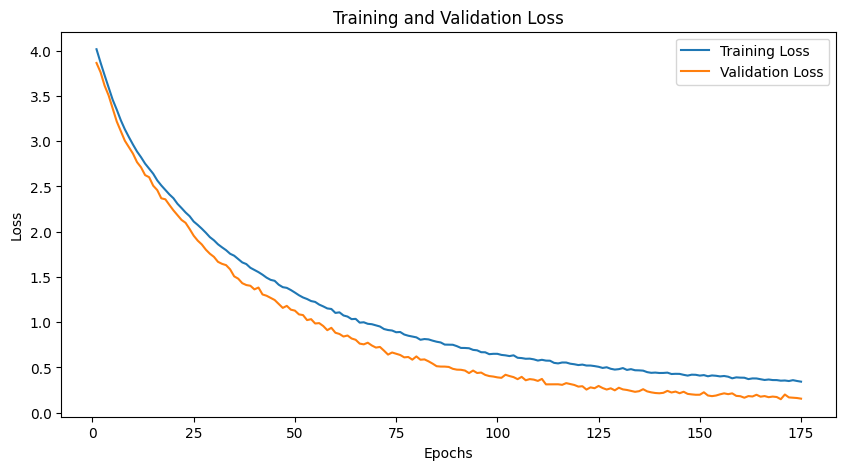

In [29]:
# Plot losses for validation and training datasets
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## 7.2. Accuracy graph

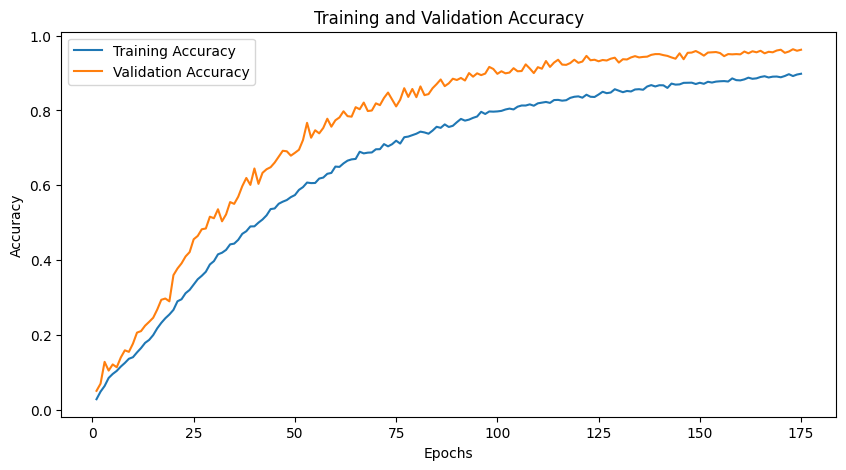

In [30]:
# Plot accuracies for validation and training datasets
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## 7.3. Epoch duration graph

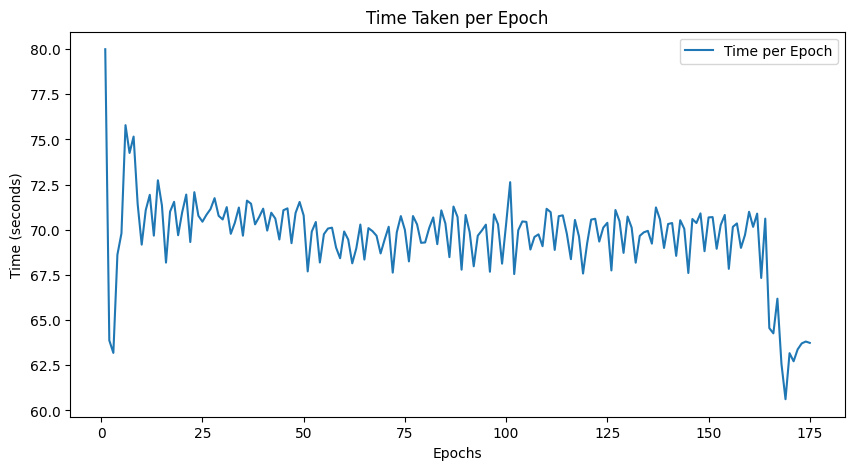

In [31]:
# Plot time taken per epoch
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, epoch_times, label='Time per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.title('Time Taken per Epoch')
plt.legend()
plt.show()